In [1]:
# from pyspark.sql import SparkSession
# import pyspark.pandas as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# spark = (
#     SparkSession.builder.appName("BNPL")
#     .config("spark.sql.repl.eagerEval.enabled", True) 
#     .config("spark.sql.parquet.cacheMetadata", "true")
#     .config("spark.driver.memory", "8g")
#     .getOrCreate()
# )

data_directory = "../data/"
tables_directory = data_directory + "tables/"
transactions_directory = tables_directory + "transactions_20210228_20210827_snapshot/"
merchants_file_loc = tables_directory + "tbl_merchants.parquet"

In [2]:
merchants = pd.read_parquet(merchants_file_loc)
transactions = pd.read_parquet(transactions_directory)
transactions = transactions.merge(merchants, how="left", on="merchant_abn")
transactions["order_datetime"] = pd.to_datetime(transactions["order_datetime"])
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3643266 entries, 0 to 3643265
Data columns (total 7 columns):
 #   Column          Dtype   
---  ------          -----   
 0   user_id         int64   
 1   merchant_abn    int64   
 2   dollar_value    float64 
 3   order_id        object  
 4   order_datetime  category
 5   name            object  
 6   tags            object  
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 201.5+ MB


In [4]:
transactions_noNull = transactions.dropna()
transactions_noNull

,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,Sed Nunc Industries,"((books, periodicals, anD newspapers), (b), (t..."
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,Cursus Non Egestas Foundation,"[(furniture, home furnishings and equipment sh..."
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,Id Erat Etiam Consulting,"[(gift, card, novelty, and souvenir shops), (b..."
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,Arcu Morbi Institute,"([artist supply and craft shops], [c], [take r..."
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,Euismod Enim LLC,"([watch, clock, and jewelry repair shops], [b]..."
...,...,...,...,...,...,...,...
3643260,18469,13514558491,615.370797,b84e4f6d-921d-455a-84b7-d27be8389526,2021-08-27,Magna Praesent PC,"[(motor vehicle supplies and new parts), (a), ..."
3643262,18471,21359184622,97.760164,8ed0f865-9f70-4e20-8266-81904c95de89,2021-08-27,Sit Amet PC,"((motor vehicle supplies and new parts), (b), ..."
3643263,18472,21807339153,54.310599,3251ce95-a850-4fbc-98d0-32bce1651d40,2021-08-27,Praesent Eu LLP,"([digital goods: books, movies, music], [c], [..."
3643264,18475,41944909975,103.804012,bd52416a-a7f1-4293-ae96-cc4a8392e414,2021-08-27,Et Nunc Consulting,"([books, periodicals, and newspapers], [e], [t..."


In [8]:
transactions_noNull.nunique()

user_id             24081
merchant_abn         3981
dollar_value      3483403
order_id          3494038
order_datetime        181
name                 3981
tags                 3910
dtype: int64

We are looking at 3981 different merchants that we can choose from. There also does not seem to be any spelling errors in the merchant names as it has the same count as the merchant_abn. 

<AxesSubplot:xlabel='name', ylabel='dollar_value'>

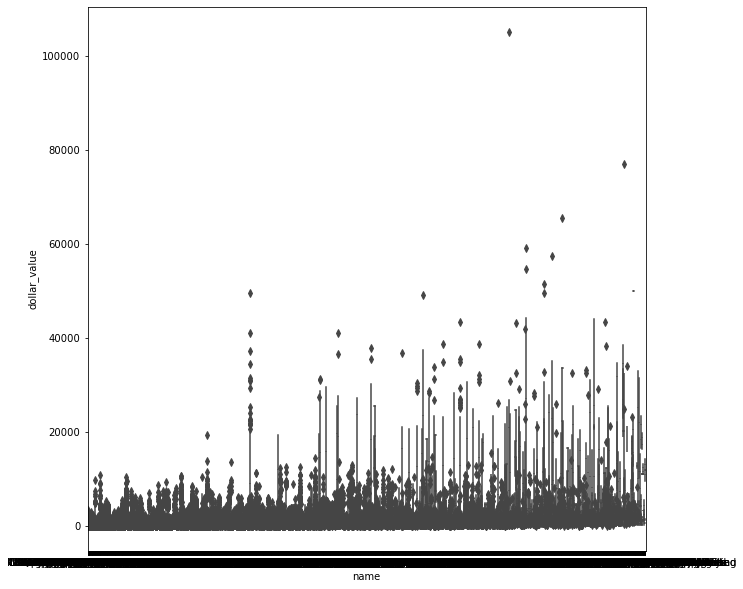

In [6]:
plt.figure(figsize=(10,10))
sns.boxplot(x='name', y='dollar_value', data = transactions_noNull)

Although it looks messy, we do see lots of outliers from different merchants, but as these would be considered rare purchases due to them being outliers, we would remove them to further improve our analysis. 

In [9]:
def is_outlier(merchant):
    Q3 = np.quantile(merchant,0.75)
    Q1 = np.quantile(merchant,0.25)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    return ~merchant.between(lower_limit, upper_limit)

In [10]:
transactions_noOutlier = transactions_noNull[~transactions_noNull.groupby('name')['dollar_value'].apply(is_outlier)]

In [12]:
transactions_noOutlier

,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,Sed Nunc Industries,"((books, periodicals, anD newspapers), (b), (t..."
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,Cursus Non Egestas Foundation,"[(furniture, home furnishings and equipment sh..."
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,Id Erat Etiam Consulting,"[(gift, card, novelty, and souvenir shops), (b..."
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,Arcu Morbi Institute,"([artist supply and craft shops], [c], [take r..."
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,Euismod Enim LLC,"([watch, clock, and jewelry repair shops], [b]..."
...,...,...,...,...,...,...,...
3643260,18469,13514558491,615.370797,b84e4f6d-921d-455a-84b7-d27be8389526,2021-08-27,Magna Praesent PC,"[(motor vehicle supplies and new parts), (a), ..."
3643262,18471,21359184622,97.760164,8ed0f865-9f70-4e20-8266-81904c95de89,2021-08-27,Sit Amet PC,"((motor vehicle supplies and new parts), (b), ..."
3643263,18472,21807339153,54.310599,3251ce95-a850-4fbc-98d0-32bce1651d40,2021-08-27,Praesent Eu LLP,"([digital goods: books, movies, music], [c], [..."
3643264,18475,41944909975,103.804012,bd52416a-a7f1-4293-ae96-cc4a8392e414,2021-08-27,Et Nunc Consulting,"([books, periodicals, and newspapers], [e], [t..."


3494038 - 3380056 = 113982 rows, that were outliers,were removed from the data, which is ~3% of all rows. 